## Average Document Size

Chunk size affects the average document size, while overlap ratio mostly affects the number of documents.  
We limit the maximum number of retrieved documents according to the total document tokens, which we limit at 3K.

| Chunk Size | Median N Tokens | Max Top K |
| :- | :-: | :- |
| 128 | 120 | 20 |
| 256 | 250 | 10 |
| 512 | 500 | 5 |

In [6]:
import json
from pathlib import Path

doc_src_paths = list(map(str, sorted(Path('data/').rglob('*.md'))))

with open('data/doc_src_paths.json', 'w') as f:
    json.dump(doc_src_paths, f, indent=2)

In [8]:
import os
from pathlib import Path

import numpy as np
from transformers import AutoTokenizer
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter

os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def get_doc_size_stats(chunk_size, overlap_ratio):
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    doc_sizes = []
    for doc in docs:
        inputs = tokenizer(doc.page_content, padding=False, truncation=False, return_tensors='pt')
        doc_size = inputs['input_ids'].size(1)
        doc_sizes.append(doc_size)

    print(
        f'{chunk_size=},\tchunk_overlap={int(chunk_size*overlap_ratio)};\t'
        f'n_docs={len(docs)},\tdoc_size stats (10% / 50% / 90%): '
        f'{int(np.percentile(doc_sizes, 10))}\t/ {int(np.percentile(doc_sizes, 50))}\t/ {int(np.percentile(doc_sizes, 90))}'
    )

for chunk_size_ in [128, 256, 512]:
    for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
        get_doc_size_stats(chunk_size_, overlap_ratio_)

chunk_size=128,	chunk_overlap=0;	n_docs=4748,	doc_size stats (10% / 50% / 90%): 61	/ 116	/ 140
chunk_size=128,	chunk_overlap=32;	n_docs=5521,	doc_size stats (10% / 50% / 90%): 58	/ 115	/ 139
chunk_size=128,	chunk_overlap=64;	n_docs=7734,	doc_size stats (10% / 50% / 90%): 63	/ 116	/ 142
chunk_size=128,	chunk_overlap=96;	n_docs=12815,	doc_size stats (10% / 50% / 90%): 42	/ 120	/ 152
chunk_size=256,	chunk_overlap=0;	n_docs=2187,	doc_size stats (10% / 50% / 90%): 171	/ 245	/ 289
chunk_size=256,	chunk_overlap=64;	n_docs=2661,	doc_size stats (10% / 50% / 90%): 174	/ 245	/ 291
chunk_size=256,	chunk_overlap=128;	n_docs=3776,	doc_size stats (10% / 50% / 90%): 186	/ 246	/ 292
chunk_size=256,	chunk_overlap=192;	n_docs=6849,	doc_size stats (10% / 50% / 90%): 203	/ 247	/ 301
chunk_size=512,	chunk_overlap=0;	n_docs=1055,	doc_size stats (10% / 50% / 90%): 376	/ 505	/ 611
chunk_size=512,	chunk_overlap=128;	n_docs=1304,	doc_size stats (10% / 50% / 90%): 400	/ 505	/ 601
chunk_size=512,	chunk_overlap=256

## Reducing Irrelevant Documents

We want the retriever to be able to refuse to retrieve, since refusal is a better answer than an incorrect one.  
We can do this by setting a upper limit to the distance or ensembling retrievers.

### Single Retriever with A Distance Threshold

We set a minimal accuracy of 70% and see which configuration offers the best accuracy and refusal capability tradeoff.  
Results show that `BAAI/bge-base-en-v1.5` with the configuration below is able to:

- Drop 89% of documents in response to OOD queries
- Maintaining 73.3% accuracy

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 128 | 0.50 | 20 | 0.75 | 0.890 | 0.733 | 8.422 |

#### GTE

Best config:

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency |
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 128 | 0.00 | 20 | 1.00 | 0.580 | 0.756 | 5.943 |

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 128 | 0.00 | 10 | 1.00 | 0.560 | 0.756 | 5.964 |
| 128 | 0.25 | 10 | 1.00 | 0.520 | 0.711 | 6.530 |
| 128 | 0.50 | 10 | 1.00 | 0.480 | 0.733 | 8.101 |
| 128 | 0.75 | 10 | 1.00 | 0.360 | 0.711 | 11.889 |
| 128 | 0.00 | 15 | 1.00 | 0.573 | 0.756 | 5.943 |
| 128 | 0.25 | 15 | 1.00 | 0.547 | 0.733 | 6.506 |
| 128 | 0.50 | 15 | 1.00 | 0.520 | 0.778 | 8.099 |
| 128 | 0.75 | 15 | 1.00 | 0.440 | 0.800 | 11.883 |
| 128 | 0.00 | 20 | 1.00 | 0.580 | 0.756 | 5.943 |
| 128 | 0.25 | 20 | 1.00 | 0.560 | 0.733 | 6.497 |
| 128 | 0.50 | 20 | 1.00 | 0.540 | 0.778 | 8.104 |
| 128 | 0.75 | 20 | 1.00 | 0.480 | 0.800 | 12.280 |
| 256 | 0.50 | 10 | 1.00 | 0.540 | 0.711 | 5.521 |

In [7]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'Alibaba-NLP/gte-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state.mean(dim=1), p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_gte_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    sum_t = 0.0
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        sum_t += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs, t = retrieve_docs(query)
        sum_t += t
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    acc = n_pos / (len(bmk) + len(ood_bmk))
    drop_ratio = n_drop / (top_k * len(ood_bmk))
    ltc = sum_t / (len(bmk) + len(ood_bmk))
    if acc > 0.7:
        print(f'| {chunk_size} | {overlap_ratio:.2f} | {top_k} | {max_dist:.2f} | {drop_ratio:.3f} | {acc:.3f} | {ltc:.3f} |')


print('| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)')
print('| :-: | :- | :- | :-: | :-: | :-: | :-: |')

configs = [
    (128, 5), (128, 10), (128, 15), (128, 20),
    (256, 5), (256, 10),
    (512, 5)
]
for chunk_size_, top_k_ in configs:
    for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
        for max_dist_ in [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
            benchmark_retriever(chunk_size_, overlap_ratio_, top_k_, max_dist_)

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: |
| 128 | 0.00 | 10 | 1.00 | 0.560 | 0.756 | 5.964 |
| 128 | 0.25 | 10 | 1.00 | 0.520 | 0.711 | 6.530 |
| 128 | 0.50 | 10 | 1.00 | 0.480 | 0.733 | 8.101 |
| 128 | 0.75 | 10 | 1.00 | 0.360 | 0.711 | 11.889 |
| 128 | 0.00 | 15 | 1.00 | 0.573 | 0.756 | 5.943 |
| 128 | 0.25 | 15 | 1.00 | 0.547 | 0.733 | 6.506 |
| 128 | 0.50 | 15 | 1.00 | 0.520 | 0.778 | 8.099 |
| 128 | 0.75 | 15 | 1.00 | 0.440 | 0.800 | 11.883 |
| 128 | 0.00 | 20 | 1.00 | 0.580 | 0.756 | 5.943 |
| 128 | 0.25 | 20 | 1.00 | 0.560 | 0.733 | 6.497 |
| 128 | 0.50 | 20 | 1.00 | 0.540 | 0.778 | 8.104 |
| 128 | 0.75 | 20 | 1.00 | 0.480 | 0.800 | 12.280 |
| 256 | 0.50 | 10 | 1.00 | 0.540 | 0.711 | 5.521 |


#### BGE

Best config:

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 128 | 0.50 | 20 | 0.75 | 0.890 | 0.733 | 8.422 |

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 128 | 0.25 | 10 | 0.85 | 0.500 | 0.711 | 6.582 |
| 128 | 0.25 | 10 | 0.90 | 0.300 | 0.711 | 6.570 |
| 128 | 0.25 | 10 | 1.00 | 0.000 | 0.711 | 6.564 |
| 128 | 0.75 | 10 | 0.85 | 0.300 | 0.711 | 12.782 |
| 128 | 0.75 | 10 | 0.90 | 0.200 | 0.733 | 12.791 |
| 128 | 0.75 | 10 | 1.00 | 0.000 | 0.711 | 12.779 |
| 128 | 0.25 | 15 | 0.80 | 0.733 | 0.711 | 6.573 |
| 128 | 0.25 | 15 | 0.85 | 0.533 | 0.756 | 6.567 |
| 128 | 0.25 | 15 | 0.90 | 0.400 | 0.778 | 6.551 |
| 128 | 0.25 | 15 | 1.00 | 0.000 | 0.756 | 6.597 |
| 128 | 0.50 | 15 | 0.75 | 0.853 | 0.711 | 8.450 |
| 128 | 0.50 | 15 | 0.80 | 0.693 | 0.733 | 8.425 |
| 128 | 0.50 | 15 | 0.85 | 0.520 | 0.733 | 8.665 |
| 128 | 0.50 | 15 | 0.90 | 0.413 | 0.733 | 8.640 |
| 128 | 0.50 | 15 | 1.00 | 0.000 | 0.733 | 8.698 |
| 128 | 0.75 | 15 | 0.85 | 0.400 | 0.756 | 12.761 |
| 128 | 0.75 | 15 | 0.90 | 0.200 | 0.756 | 12.790 |
| 128 | 0.75 | 15 | 1.00 | 0.000 | 0.733 | 12.768 |
| 128 | 0.25 | 20 | 0.80 | 0.750 | 0.711 | 6.867 |
| 128 | 0.25 | 20 | 0.85 | 0.550 | 0.756 | 6.888 |
| 128 | 0.25 | 20 | 0.90 | 0.450 | 0.756 | 7.147 |
| 128 | 0.25 | 20 | 1.00 | 0.000 | 0.756 | 6.588 |
| 128 | 0.50 | 20 | 0.75 | 0.890 | 0.733 | 8.422 |
| 128 | 0.50 | 20 | 0.80 | 0.720 | 0.756 | 8.440 |
| 128 | 0.50 | 20 | 0.85 | 0.540 | 0.756 | 8.438 |
| 128 | 0.50 | 20 | 0.90 | 0.460 | 0.756 | 8.440 |
| 128 | 0.50 | 20 | 1.00 | 0.000 | 0.756 | 8.447 |
| 128 | 0.75 | 20 | 0.80 | 0.650 | 0.711 | 12.784 |
| 128 | 0.75 | 20 | 0.85 | 0.450 | 0.756 | 12.783 |
| 128 | 0.75 | 20 | 0.90 | 0.290 | 0.756 | 12.776 |
| 128 | 0.75 | 20 | 1.00 | 0.000 | 0.756 | 12.789 |
| 256 | 0.25 | 5 | 0.90 | 0.360 | 0.711 | 4.581 |
| 256 | 0.25 | 10 | 0.85 | 0.580 | 0.733 | 4.499 |
| 256 | 0.25 | 10 | 0.90 | 0.480 | 0.733 | 4.497 |
| 256 | 0.25 | 10 | 1.00 | 0.000 | 0.733 | 4.594 |
| 512 | 0.25 | 5 | 1.00 | 0.000 | 0.733 | 3.687 |
| 512 | 0.50 | 5 | 0.90 | 0.480 | 0.711 | 4.168 |
| 512 | 0.50 | 5 | 1.00 | 0.000 | 0.711 | 4.153 |

In [8]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    sum_t = 0.0
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        sum_t += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs, t = retrieve_docs(query)
        sum_t += t
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    acc = n_pos / (len(bmk) + len(ood_bmk))
    drop_ratio = n_drop / (top_k * len(ood_bmk))
    avg_t = sum_t / (len(bmk) + len(ood_bmk))
    if acc > 0.7:
        print(f'| {chunk_size} | {overlap_ratio:.2f} | {top_k} | {max_dist:.2f} | {drop_ratio:.3f} | {acc:.3f} | {avg_t:.3f} |')


print('| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)')
print('| :-: | :- | :- | :-: | :-: | :-: | :-: |')

configs = [
    (128, 5), (128, 10), (128, 15), (128, 20),
    (256, 5), (256, 10),
    (512, 5)
]
for chunk_size_, top_k_ in configs:
    for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
        for max_dist_ in [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
            benchmark_retriever(chunk_size_, overlap_ratio_, top_k_, max_dist_)

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 128 | 0.25 | 10 | 0.85 | 0.500 | 0.711 | 6.582 |
| 128 | 0.25 | 10 | 0.90 | 0.300 | 0.711 | 6.570 |
| 128 | 0.25 | 10 | 1.00 | 0.000 | 0.711 | 6.564 |
| 128 | 0.75 | 10 | 0.85 | 0.300 | 0.711 | 12.782 |
| 128 | 0.75 | 10 | 0.90 | 0.200 | 0.733 | 12.791 |
| 128 | 0.75 | 10 | 1.00 | 0.000 | 0.711 | 12.779 |
| 128 | 0.25 | 15 | 0.80 | 0.733 | 0.711 | 6.573 |
| 128 | 0.25 | 15 | 0.85 | 0.533 | 0.756 | 6.567 |
| 128 | 0.25 | 15 | 0.90 | 0.400 | 0.778 | 6.551 |
| 128 | 0.25 | 15 | 1.00 | 0.000 | 0.756 | 6.597 |
| 128 | 0.50 | 15 | 0.75 | 0.853 | 0.711 | 8.450 |
| 128 | 0.50 | 15 | 0.80 | 0.693 | 0.733 | 8.425 |
| 128 | 0.50 | 15 | 0.85 | 0.520 | 0.733 | 8.665 |
| 128 | 0.50 | 15 | 0.90 | 0.413 | 0.733 | 8.640 |
| 128 | 0.50 | 15 | 1.00 | 0.000 | 0.733 | 8.698 |
| 128 | 0.75 | 15 | 0.85 | 0.400 | 0.756 | 12.761 |
| 128 | 0.75 | 15 | 0.90 | 0.200 | 0.756 | 

### Ensemble Retriever

Best config:

| Chunk Size | Overlap Ratio | N Trees | Top K | OOD Drop Ratio | Accuracy | Latency (ms) |
| :-: | :-: | :- | :- | :-: | :-: | -: |
| 128 | 0.25 | 5521 | 20 | 0.700 | 0.733 | 15.8224 |

| Chunk Size | Overlap Ratio | N Trees | Top K | OOD Drop Ratio | Accuracy | Latency (ms) |
| :-: | :-: | :- | :- | :-: | :-: | -: |
| 128 | 0.00 | 4748 | 5 | 0.720 | 0.600 | 12.3267 |
| 128 | 0.25 | 5521 | 5 | 0.640 | 0.578 | 13.3409 |
| 128 | 0.50 | 7734 | 5 | 0.640 | 0.578 | 16.4851 |
| 128 | 0.75 | 12815 | 5 | 0.720 | 0.578 | 26.2020 |
| 128 | 0.00 | 4748 | 10 | 0.780 | 0.667 | 13.1385 |
| 128 | 0.25 | 5521 | 10 | 0.640 | 0.667 | 14.1887 |
| 128 | 0.50 | 7734 | 10 | 0.660 | 0.622 | 17.5569 |
| 128 | 0.75 | 12815 | 10 | 0.560 | 0.667 | 26.1604 |
| 128 | 0.00 | 4748 | 15 | 0.720 | 0.667 | 13.2161 |
| 128 | 0.25 | 5521 | 15 | 0.693 | 0.733 | 14.2840 |
| 128 | 0.50 | 7734 | 15 | 0.707 | 0.689 | 17.7438 |
| 128 | 0.75 | 12815 | 15 | 0.573 | 0.711 | 26.8690 |
| 128 | 0.00 | 4748 | 20 | 0.710 | 0.667 | 14.0523 |
| 128 | 0.25 | 5521 | 20 | 0.700 | 0.733 | 15.8224 |
| 128 | 0.50 | 7734 | 20 | 0.700 | 0.711 | 19.4214 |
| 128 | 0.75 | 12815 | 20 | 0.570 | 0.733 | 28.5393 |
| 256 | 0.00 | 2187 | 5 | 0.560 | 0.622 | 9.0478 |
| 256 | 0.25 | 2661 | 5 | 0.640 | 0.578 | 9.7969 |
| 256 | 0.50 | 3776 | 5 | 0.640 | 0.533 | 11.3254 |
| 256 | 0.75 | 6849 | 5 | 0.640 | 0.600 | 15.3273 |
| 256 | 0.00 | 2187 | 10 | 0.620 | 0.667 | 9.2371 |
| 256 | 0.25 | 2661 | 10 | 0.640 | 0.622 | 9.8986 |
| 256 | 0.50 | 3776 | 10 | 0.640 | 0.622 | 12.2380 |
| 256 | 0.75 | 6849 | 10 | 0.600 | 0.600 | 16.7902 |
| 512 | 0.00 | 1055 | 5 | 0.640 | 0.511 | 8.4820 |
| 512 | 0.25 | 1304 | 5 | 0.520 | 0.600 | 7.9980 |
| 512 | 0.50 | 1859 | 5 | 0.600 | 0.578 | 8.6953 |
| 512 | 0.75 | 3401 | 5 | 0.640 | 0.400 | 11.1432 |



In [6]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name1 = 'BAAI/bge-base-en-v1.5'
tokenizer1 = AutoTokenizer.from_pretrained(model_name1)
model1 = AutoModel.from_pretrained(model_name1).to('cuda')

model_name2 = 'Alibaba-NLP/gte-base-en-v1.5'
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
model2 = AutoModel.from_pretrained(model_name2, trust_remote_code=True).to('cuda')


@torch.no_grad()
def vector_embed1(text):
    input_tokens = tokenizer1(text, padding=True, truncation=True, return_tensors='pt')
    output = model1(**{k: v.to(model1.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


@torch.no_grad()
def vector_embed2(text):
    input_tokens = tokenizer2(text, padding=True, truncation=True, return_tensors='pt')
    output = model2(**{k: v.to(model2.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state.mean(dim=1), p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def benchmark_ens_retriever(chunk_size, overlap_ratio, top_k):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    n_trees = len(docs)
    # Creating vector index 1
    filename1 = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx1 = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename1).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed1(doc.page_content)
            vector_idx1.add_item(i, embd)
        vector_idx1.build(n_trees)
        vector_idx1.save(filename1)
    else:
        vector_idx1.load(filename1)

    # Creating vector index 2
    filename2 = f'.ann/idx_gte_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx2 = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename2).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed2(doc.page_content)
            vector_idx2.add_item(i, embd)
        vector_idx2.build(n_trees)
        vector_idx2.save(filename2)
    else:
        vector_idx2.load(filename2)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd1 = vector_embed1(query)
        idxs1, dists1 = vector_idx1.get_nns_by_vector(q_embd1, top_k, len(docs), include_distances=True)
        dist_idx1 = dict(zip(idxs1, dists1))

        q_embd2 = vector_embed2(query)
        idxs2, dists2 = vector_idx2.get_nns_by_vector(q_embd2, top_k, len(docs), include_distances=True)
        dist_idx2 = dict(zip(idxs2, dists2))

        top_doc_idxs = dist_idx1.keys() & dist_idx2.keys()
        dist_idx = []
        for idx in top_doc_idxs:
            avg_dist = (dist_idx1[idx] + dist_idx2[idx]) / 2
            dist_idx.append((avg_dist, idx))
    
        top_docs = []
        for dist, idx in sorted(dist_idx):
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    t_sum = 0.0
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        t_sum += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs, t = retrieve_docs(query)
        t_sum += t
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    drop_ratio = n_drop / (top_k * len(ood_bmk))
    acc = n_pos / (len(bmk) + len(ood_bmk))
    avg_t = t_sum / (len(bmk) + len(ood_bmk))
    print(f'| {chunk_size} | {overlap_ratio:.2f} | {n_trees} | {top_k} | {drop_ratio:.3f} | {acc:.3f} | {avg_t:.4f} |')


print('| Chunk Size | Overlap Ratio | N Trees | Top K | OOD Drop Ratio | Accuracy | Latency (ms) |')
print('| :-: | :-: | :- | :- | :-: | :-: | -: |')
configs = [
    (128, 5), (128, 10), (128, 15), (128, 20),
    (256, 5), (256, 10),
    (512, 5)
]
for chunk_size_, top_k_ in configs:
    for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
        benchmark_ens_retriever(chunk_size_, overlap_ratio_, top_k_)

| Chunk Size | Overlap Ratio | N Trees | Top K | OOD Drop Ratio | Accuracy | Latency (ms) |
| :-: | :-: | :- | :- | :-: | :-: | -: |
| 128 | 0.00 | 4748 | 5 | 0.720 | 0.600 | 12.1985 |
| 128 | 0.25 | 5521 | 5 | 0.640 | 0.578 | 13.2861 |
| 128 | 0.50 | 7734 | 5 | 0.640 | 0.578 | 16.4096 |
| 128 | 0.75 | 12815 | 5 | 0.720 | 0.578 | 24.4618 |
| 128 | 0.00 | 4748 | 10 | 0.780 | 0.667 | 12.1965 |
| 128 | 0.25 | 5521 | 10 | 0.640 | 0.667 | 13.1868 |
| 128 | 0.50 | 7734 | 10 | 0.660 | 0.622 | 16.3386 |
| 128 | 0.75 | 12815 | 10 | 0.560 | 0.667 | 24.4350 |
| 128 | 0.00 | 4748 | 15 | 0.720 | 0.667 | 12.1609 |
| 128 | 0.25 | 5521 | 15 | 0.693 | 0.733 | 13.1987 |
| 128 | 0.50 | 7734 | 15 | 0.707 | 0.689 | 16.3466 |
| 128 | 0.75 | 12815 | 15 | 0.573 | 0.711 | 24.4641 |
| 128 | 0.00 | 4748 | 20 | 0.710 | 0.667 | 12.1729 |
| 128 | 0.25 | 5521 | 20 | 0.700 | 0.733 | 13.2021 |
| 128 | 0.50 | 7734 | 20 | 0.700 | 0.711 | 16.3289 |
| 128 | 0.75 | 12815 | 20 | 0.570 | 0.733 | 24.4602 |
| 256 | 0.00 | 2187

In [3]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'Alibaba-NLP/gte-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state.mean(dim=1), p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    doc_src_paths = list(Path('data/').rglob('*.md'))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_gte_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs = retrieve_docs(query)
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs = retrieve_docs(query)
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    acc = n_pos / (len(bmk) + len(ood_bmk))
    drop_ratio = n_drop / (top_k * len(ood_bmk))
    print(f'| {max_dist:.2f} | {drop_ratio:.3f} | {acc:.3f} |')


print('| Max Distance | OOD Drop Ratio | Accuracy |')
print('| :-: | :-: | :-: |')
max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
for max_dist_ in max_dists:
    benchmark_retriever(128, 0.5, 20, max_dist_)

| Max Distance | OOD Drop Ratio | Accuracy |
| :-: | :-: | :-: |
| 0.70 | 1.000 | 0.156 |
| 0.75 | 1.000 | 0.244 |
| 0.80 | 0.990 | 0.400 |
| 0.85 | 0.960 | 0.578 |
| 0.90 | 0.730 | 0.711 |
| 1.00 | 0.510 | 0.800 |


## Ablation Experiments

### Accuracy vs. (overlap ratio, top k) of BGE w/ chunk size 128

In [2]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    sum_t = 0.0
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        sum_t += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs, t = retrieve_docs(query)
        sum_t += t
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    acc = n_pos / (len(bmk) + len(ood_bmk))
    drop_ratio = n_drop / (top_k * len(ood_bmk))
    avg_t = sum_t / (len(bmk) + len(ood_bmk))
    print(f'| {chunk_size} | {overlap_ratio:.2f} | {top_k} | {max_dist:.2f} | {drop_ratio:.3f} | {acc:.3f} | {avg_t:.3f} |')


print('| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)')
print('| :-: | :- | :- | :-: | :-: | :-: | :-: |')

configs = [
    (128, 5), (128, 10), (128, 15), (128, 20),
    (256, 5), (256, 10),
    (512, 5)
]
for chunk_size_, top_k_ in configs:
    for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
        for max_dist_ in [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
            if chunk_size_ == 128 and max_dist_ > 0.95:
                benchmark_retriever(chunk_size_, overlap_ratio_, top_k_, max_dist_)

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 128 | 0.00 | 5 | 1.00 | 0.000 | 0.667 | 5.907 |
| 128 | 0.25 | 5 | 1.00 | 0.000 | 0.644 | 6.535 |
| 128 | 0.50 | 5 | 1.00 | 0.000 | 0.644 | 8.455 |
| 128 | 0.75 | 5 | 1.00 | 0.000 | 0.667 | 12.737 |
| 128 | 0.00 | 10 | 1.00 | 0.000 | 0.689 | 5.880 |
| 128 | 0.25 | 10 | 1.00 | 0.000 | 0.711 | 6.517 |
| 128 | 0.50 | 10 | 1.00 | 0.000 | 0.689 | 8.381 |
| 128 | 0.75 | 10 | 1.00 | 0.000 | 0.711 | 12.662 |
| 128 | 0.00 | 15 | 1.00 | 0.000 | 0.689 | 5.906 |
| 128 | 0.25 | 15 | 1.00 | 0.000 | 0.756 | 6.553 |
| 128 | 0.50 | 15 | 1.00 | 0.000 | 0.733 | 8.382 |
| 128 | 0.75 | 15 | 1.00 | 0.000 | 0.733 | 12.653 |
| 128 | 0.00 | 20 | 1.00 | 0.000 | 0.689 | 5.941 |
| 128 | 0.25 | 20 | 1.00 | 0.000 | 0.756 | 6.572 |
| 128 | 0.50 | 20 | 1.00 | 0.000 | 0.756 | 8.425 |
| 128 | 0.75 | 20 | 1.00 | 0.000 | 0.756 | 12.757 |


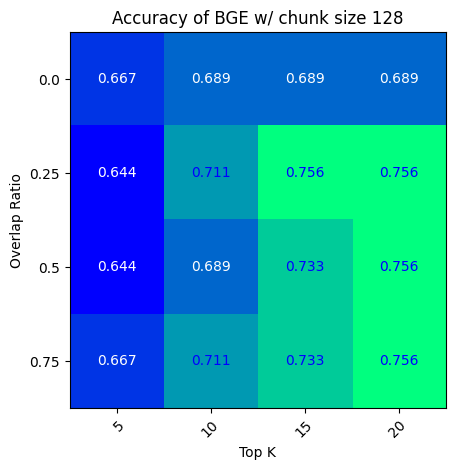

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


overlap_ratios = [0.0, 0.25, 0.5, 0.75]
top_ks = [5, 10, 15, 20]

accs = np.array([
    [0.667, 0.689, 0.689, 0.689],
    [0.644, 0.711, 0.756, 0.756],
    [0.644, 0.689, 0.733, 0.756],
    [0.667, 0.711, 0.733, 0.756]
])


fig, ax = plt.subplots()
im = ax.imshow(accs, cmap='winter')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(top_ks)), labels=top_ks)
ax.set_xlabel('Top K')

ax.set_yticks(np.arange(len(overlap_ratios)), labels=overlap_ratios)
ax.set_ylabel('Overlap Ratio')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(overlap_ratios)):
    for j in range(len(top_ks)):
        text = ax.text(j, i, accs[i, j], ha="center", va="center", color="w" if accs[i, j] < 0.7 else 'b')

ax.set_title("Accuracy of BGE w/ chunk size 128")
fig.tight_layout()
plt.savefig('acc_bge_cs128.svg', format='svg')
plt.show()

### Accuracy vs. (overlap ratio, top k) of BGE w/ chunk size 256

In [11]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    sum_t = 0.0
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        sum_t += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs, t = retrieve_docs(query)
        sum_t += t
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    acc = n_pos / (len(bmk) + len(ood_bmk))
    drop_ratio = n_drop / (top_k * len(ood_bmk))
    avg_t = sum_t / (len(bmk) + len(ood_bmk))
    print(f'| {chunk_size} | {overlap_ratio:.2f} | {top_k} | {max_dist:.2f} | {drop_ratio:.3f} | {acc:.3f} | {avg_t:.3f} |')


print('| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)')
print('| :-: | :- | :- | :-: | :-: | :-: | :-: |')

configs = [
    (128, 5), (128, 10), (128, 15), (128, 20),
    (256, 5), (256, 10),
    (512, 5)
]
for chunk_size_, top_k_ in configs:
    for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
        for max_dist_ in [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
            if chunk_size_ == 256 and max_dist_ > 0.95:
                benchmark_retriever(chunk_size_, overlap_ratio_, top_k_, max_dist_)

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 256 | 0.00 | 5 | 1.00 | 0.000 | 0.667 | 3.849 |
| 256 | 0.25 | 5 | 1.00 | 0.000 | 0.689 | 4.232 |
| 256 | 0.50 | 5 | 1.00 | 0.000 | 0.556 | 5.064 |
| 256 | 0.75 | 5 | 1.00 | 0.000 | 0.622 | 7.658 |
| 256 | 0.00 | 10 | 1.00 | 0.000 | 0.689 | 3.827 |
| 256 | 0.25 | 10 | 1.00 | 0.000 | 0.733 | 4.266 |
| 256 | 0.50 | 10 | 1.00 | 0.000 | 0.622 | 5.021 |
| 256 | 0.75 | 10 | 1.00 | 0.000 | 0.667 | 7.673 |


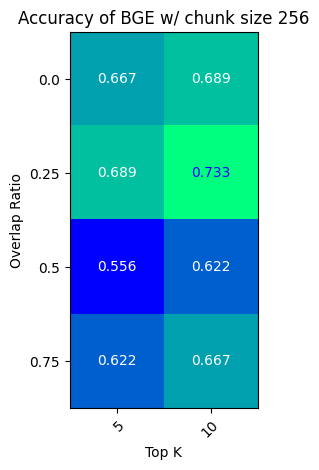

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


overlap_ratios = [0.0, 0.25, 0.5, 0.75]
top_ks = [5, 10]

accs = np.array([
    [0.667, 0.689, 0.556, 0.622],
    [0.689, 0.733, 0.622, 0.667]
])
accs = accs.T


fig, ax = plt.subplots()
im = ax.imshow(accs, cmap='winter')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(top_ks)), labels=top_ks)
ax.set_xlabel('Top K')

ax.set_yticks(np.arange(len(overlap_ratios)), labels=overlap_ratios)
ax.set_ylabel('Overlap Ratio')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(overlap_ratios)):
    for j in range(len(top_ks)):
        text = ax.text(j, i, accs[i, j], ha="center", va="center", color="w" if accs[i, j] < 0.7 else 'b')

ax.set_title("Accuracy of BGE w/ chunk size 256")
fig.tight_layout()
plt.savefig('acc_bge_cs256.svg', format='svg')
plt.show()

### Accuracy vs. (overlap ratio, top k) of BGE w/ chunk size 512

In [14]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    sum_t = 0.0
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        sum_t += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs, t = retrieve_docs(query)
        sum_t += t
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    acc = n_pos / (len(bmk) + len(ood_bmk))
    drop_ratio = n_drop / (top_k * len(ood_bmk))
    avg_t = sum_t / (len(bmk) + len(ood_bmk))
    print(f'| {chunk_size} | {overlap_ratio:.2f} | {top_k} | {max_dist:.2f} | {drop_ratio:.3f} | {acc:.3f} | {avg_t:.3f} |')


print('| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)')
print('| :-: | :- | :- | :-: | :-: | :-: | :-: |')

configs = [
    (128, 5), (128, 10), (128, 15), (128, 20),
    (256, 5), (256, 10),
    (512, 5)
]
for chunk_size_, top_k_ in configs:
    for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
        for max_dist_ in [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
            if chunk_size_ == 512 and max_dist_ > 0.95:
                benchmark_retriever(chunk_size_, overlap_ratio_, top_k_, max_dist_)

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 512 | 0.00 | 5 | 1.00 | 0.000 | 0.667 | 3.400 |
| 512 | 0.25 | 5 | 1.00 | 0.000 | 0.733 | 3.437 |
| 512 | 0.50 | 5 | 1.00 | 0.000 | 0.711 | 3.633 |
| 512 | 0.75 | 5 | 1.00 | 0.000 | 0.644 | 4.818 |


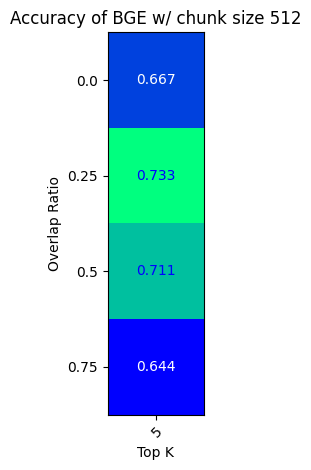

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


overlap_ratios = [0.0, 0.25, 0.5, 0.75]
top_ks = [5]

accs = np.array([[0.667, 0.733, 0.711, 0.644]])
accs = accs.T


fig, ax = plt.subplots()
im = ax.imshow(accs, cmap='winter')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(top_ks)), labels=top_ks)
ax.set_xlabel('Top K')

ax.set_yticks(np.arange(len(overlap_ratios)), labels=overlap_ratios)
ax.set_ylabel('Overlap Ratio')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(overlap_ratios)):
    for j in range(len(top_ks)):
        text = ax.text(j, i, accs[i, j], ha="center", va="center", color="w" if accs[i, j] < 0.7 else 'b')

ax.set_title("Accuracy of BGE w/ chunk size 512")
fig.tight_layout()
plt.savefig('acc_bge_cs512.svg', format='svg')
plt.show()

### Accuracy vs. (distance threshold, overlap ratio) of BGE w/ chunk size 128, top k 20

In [8]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')

ACCS_BGE = []
OOD_DRS_BGE = []


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    sum_t = 0.0
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        sum_t += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs, t = retrieve_docs(query)
        sum_t += t
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    acc = n_pos / (len(bmk) + len(ood_bmk))
    drop_ratio = n_drop / (top_k * len(ood_bmk))
    avg_t = sum_t / (len(bmk) + len(ood_bmk))
    print(f'| {chunk_size} | {overlap_ratio:.2f} | {top_k} | {max_dist:.2f} | {drop_ratio:.3f} | {acc:.3f} | {avg_t:.3f} |')
    ACCS_BGE.append(acc)
    OOD_DRS_BGE.append(drop_ratio)


print('| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)')
print('| :-: | :- | :- | :-: | :-: | :-: | :-: |')


for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
    for max_dist_ in [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
        benchmark_retriever(128, overlap_ratio_, 20, max_dist_)

| Chunk Size | Overlap Ratio | Top K | Max Distance | OOD Drop Ratio | Accuracy | Latency (ms)
| :-: | :- | :- | :-: | :-: | :-: | :-: |
| 128 | 0.00 | 20 | 0.70 | 1.000 | 0.422 | 5.847 |
| 128 | 0.00 | 20 | 0.75 | 0.930 | 0.600 | 5.863 |
| 128 | 0.00 | 20 | 0.80 | 0.740 | 0.667 | 5.872 |
| 128 | 0.00 | 20 | 0.85 | 0.600 | 0.689 | 6.358 |
| 128 | 0.00 | 20 | 0.90 | 0.480 | 0.689 | 5.886 |
| 128 | 0.00 | 20 | 1.00 | 0.000 | 0.689 | 5.894 |
| 128 | 0.25 | 20 | 0.70 | 1.000 | 0.511 | 6.513 |
| 128 | 0.25 | 20 | 0.75 | 0.920 | 0.644 | 6.503 |
| 128 | 0.25 | 20 | 0.80 | 0.750 | 0.711 | 6.448 |
| 128 | 0.25 | 20 | 0.85 | 0.550 | 0.756 | 6.529 |
| 128 | 0.25 | 20 | 0.90 | 0.450 | 0.756 | 6.548 |
| 128 | 0.25 | 20 | 1.00 | 0.000 | 0.756 | 6.504 |
| 128 | 0.50 | 20 | 0.70 | 1.000 | 0.533 | 8.454 |
| 128 | 0.50 | 20 | 0.75 | 0.890 | 0.733 | 8.368 |
| 128 | 0.50 | 20 | 0.80 | 0.720 | 0.756 | 8.357 |
| 128 | 0.50 | 20 | 0.85 | 0.540 | 0.756 | 8.433 |
| 128 | 0.50 | 20 | 0.90 | 0.460 | 0.756 | 8.41

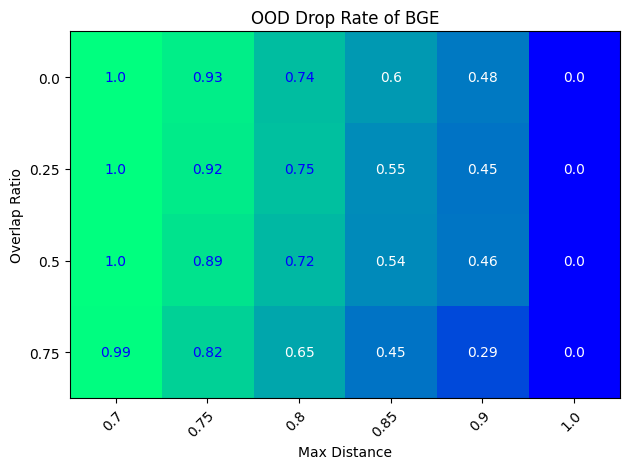

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


overlap_ratios = [0.0, 0.25, 0.5, 0.75]
max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

ood_drs = np.array([
    [1.0, 0.93, 0.74, 0.60, 0.48, 0.0],
    [1.0, 0.92, 0.75, 0.55, 0.45, 0.0],
    [1.0, 0.89, 0.72, 0.54, 0.46, 0.0],
    [0.99, 0.82, 0.65, 0.45, 0.29, 0.0]
])


fig, ax = plt.subplots()
im = ax.imshow(ood_drs, cmap='winter')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(max_dists)), labels=max_dists)
ax.set_xlabel('Max Distance')

ax.set_yticks(np.arange(len(overlap_ratios)), labels=overlap_ratios)
ax.set_ylabel('Overlap Ratio')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(overlap_ratios)):
    for j in range(len(max_dists)):
        text = ax.text(j, i, ood_drs[i, j], ha="center", va="center", color="w" if ood_drs[i, j] < 0.7 else 'b')

ax.set_title("OOD Drop Rate of BGE")
fig.tight_layout()
plt.savefig('ood_dr_bge_md.svg', format='svg')
plt.show()

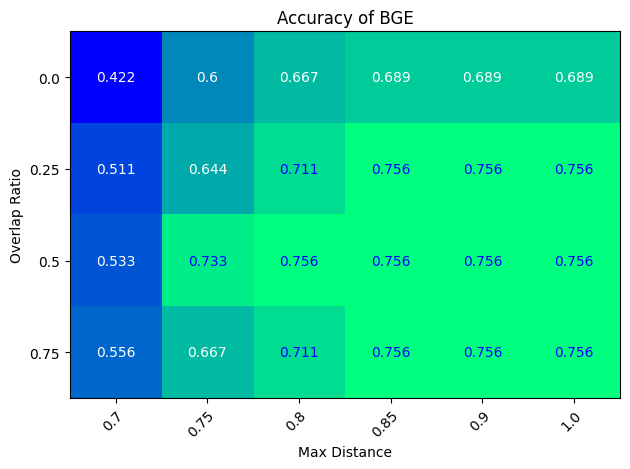

In [6]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


overlap_ratios = [0.0, 0.25, 0.5, 0.75]
max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

accs = np.array([
    [0.422, 0.600, 0.667, 0.689, 0.689, 0.689],
    [0.511, 0.644, 0.711, 0.756, 0.756, 0.756],
    [0.533, 0.733, 0.756, 0.756, 0.756, 0.756],
    [0.556, 0.667, 0.711, 0.756, 0.756, 0.756]
])



fig, ax = plt.subplots()
im = ax.imshow(accs, cmap='winter')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(max_dists)), labels=max_dists)
ax.set_xlabel('Max Distance')

ax.set_yticks(np.arange(len(overlap_ratios)), labels=overlap_ratios)
ax.set_ylabel('Overlap Ratio')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(overlap_ratios)):
    for j in range(len(max_dists)):
        text = ax.text(j, i, accs[i, j], ha="center", va="center", color="w" if accs[i, j] < 0.7 else 'b')

ax.set_title("Accuracy of BGE")
fig.tight_layout()
plt.savefig('acc_bge_md.svg', format='svg')
plt.show()

### Accuracy vs. (distance threshold, overlap ratio) of GTE w/ chunk size 128, top k 20

In [9]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'Alibaba-NLP/gte-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')

ACCS_GTE = []
OOD_DRS_GTE = []

@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state.mean(dim=1), p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_gte_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    sum_t = 0.0
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        sum_t += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs, t = retrieve_docs(query)
        sum_t += t
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    acc = n_pos / (len(bmk) + len(ood_bmk))
    drop_ratio = n_drop / (top_k * len(ood_bmk))
    avg_t = sum_t / (len(bmk) + len(ood_bmk))

    ACCS_GTE.append(acc)
    OOD_DRS_GTE.append(drop_ratio)
    print(f'| {chunk_size} | {overlap_ratio:.2f} | {top_k} | {max_dist:.2f} | {drop_ratio:.3f} | {acc:.3f} | {avg_t:.3f} |')


for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
    for max_dist_ in [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]:
        benchmark_retriever(128, overlap_ratio_, 20, max_dist_)

| 128 | 0.00 | 20 | 0.70 | 1.000 | 0.133 | 6.557 |
| 128 | 0.00 | 20 | 0.75 | 1.000 | 0.178 | 5.884 |
| 128 | 0.00 | 20 | 0.80 | 0.990 | 0.289 | 5.828 |
| 128 | 0.00 | 20 | 0.85 | 0.930 | 0.467 | 5.825 |
| 128 | 0.00 | 20 | 0.90 | 0.790 | 0.600 | 5.810 |
| 128 | 0.00 | 20 | 1.00 | 0.580 | 0.756 | 5.830 |
| 128 | 0.25 | 20 | 0.70 | 1.000 | 0.111 | 6.432 |
| 128 | 0.25 | 20 | 0.75 | 1.000 | 0.178 | 6.416 |
| 128 | 0.25 | 20 | 0.80 | 0.980 | 0.378 | 6.427 |
| 128 | 0.25 | 20 | 0.85 | 0.950 | 0.556 | 6.475 |
| 128 | 0.25 | 20 | 0.90 | 0.840 | 0.689 | 6.418 |
| 128 | 0.25 | 20 | 1.00 | 0.560 | 0.733 | 6.422 |
| 128 | 0.50 | 20 | 0.70 | 1.000 | 0.156 | 8.003 |
| 128 | 0.50 | 20 | 0.75 | 1.000 | 0.244 | 8.031 |
| 128 | 0.50 | 20 | 0.80 | 0.990 | 0.400 | 7.986 |
| 128 | 0.50 | 20 | 0.85 | 0.960 | 0.578 | 7.996 |
| 128 | 0.50 | 20 | 0.90 | 0.730 | 0.689 | 8.031 |
| 128 | 0.50 | 20 | 1.00 | 0.540 | 0.778 | 8.024 |
| 128 | 0.75 | 20 | 0.70 | 1.000 | 0.178 | 11.787 |
| 128 | 0.75 | 20 | 0.75 | 1.0

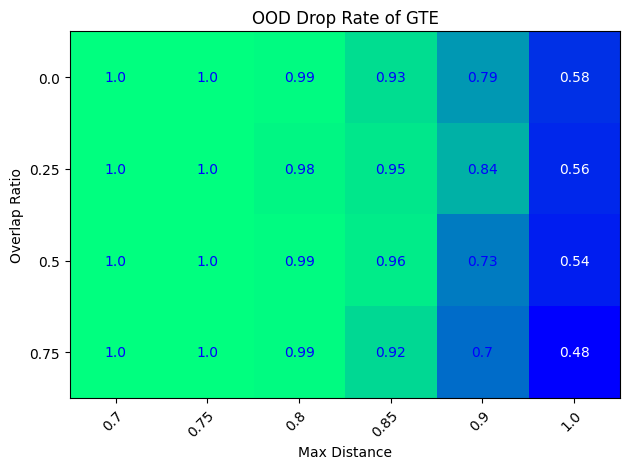

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


overlap_ratios = [0.0, 0.25, 0.5, 0.75]
max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

ood_drs = np.array(OOD_DRS).reshape([4, 6])

fig, ax = plt.subplots()
im = ax.imshow(ood_drs, cmap='winter')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(max_dists)), labels=max_dists)
ax.set_xlabel('Max Distance')

ax.set_yticks(np.arange(len(overlap_ratios)), labels=overlap_ratios)
ax.set_ylabel('Overlap Ratio')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(overlap_ratios)):
    for j in range(len(max_dists)):
        text = ax.text(j, i, ood_drs[i, j], ha="center", va="center", color="w" if ood_drs[i, j] < 0.7 else 'b')

ax.set_title("OOD Drop Rate of GTE")
fig.tight_layout()
plt.savefig('ood_dr_gte_md.svg', format='svg')
plt.show()

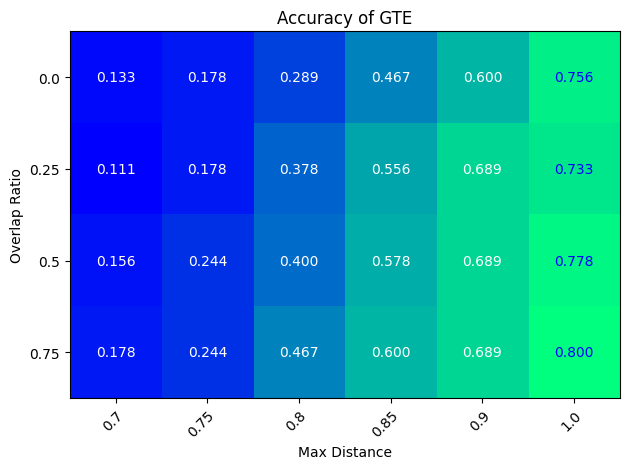

In [9]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


overlap_ratios = [0.0, 0.25, 0.5, 0.75]
max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

accs = np.array(ACCS).reshape([4, 6])



fig, ax = plt.subplots()
im = ax.imshow(accs, cmap='winter')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(max_dists)), labels=max_dists)
ax.set_xlabel('Max Distance')

ax.set_yticks(np.arange(len(overlap_ratios)), labels=overlap_ratios)
ax.set_ylabel('Overlap Ratio')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(overlap_ratios)):
    for j in range(len(max_dists)):
        text = ax.text(j, i, f'{accs[i, j]:.3f}', ha="center", va="center", color="w" if accs[i, j] < 0.7 else 'b')

ax.set_title("Accuracy of GTE")
fig.tight_layout()
plt.savefig('acc_gte_md.svg', format='svg')
plt.show()

### Accuracy vs. (BGE distance threshold, GTE distance threshold) of ensemble retreiever

Chunk size = 128, top K = 20, overlap_ratio = 0.5

In [10]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name1 = 'BAAI/bge-base-en-v1.5'
tokenizer1 = AutoTokenizer.from_pretrained(model_name1)
model1 = AutoModel.from_pretrained(model_name1).to('cuda')

model_name2 = 'Alibaba-NLP/gte-base-en-v1.5'
tokenizer2 = AutoTokenizer.from_pretrained(model_name2)
model2 = AutoModel.from_pretrained(model_name2, trust_remote_code=True).to('cuda')

ACCS_ENS = []
OOD_DRS_ENS = []


@torch.no_grad()
def vector_embed1(text):
    input_tokens = tokenizer1(text, padding=True, truncation=True, return_tensors='pt')
    output = model1(**{k: v.to(model1.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


@torch.no_grad()
def vector_embed2(text):
    input_tokens = tokenizer2(text, padding=True, truncation=True, return_tensors='pt')
    output = model2(**{k: v.to(model2.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state.mean(dim=1), p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def benchmark_ens_retriever(
    chunk_size, top_k, overlap_ratio,
    bge_max_dist, gte_max_dist
):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    n_trees = len(docs)
    # Creating vector index 1
    filename1 = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx1 = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename1).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed1(doc.page_content)
            vector_idx1.add_item(i, embd)
        vector_idx1.build(n_trees)
        vector_idx1.save(filename1)
    else:
        vector_idx1.load(filename1)

    # Creating vector index 2
    filename2 = f'.ann/idx_gte_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx2 = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename2).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed2(doc.page_content)
            vector_idx2.add_item(i, embd)
        vector_idx2.build(n_trees)
        vector_idx2.save(filename2)
    else:
        vector_idx2.load(filename2)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd1 = vector_embed1(query)
        idxs1, dists1 = vector_idx1.get_nns_by_vector(q_embd1, top_k, len(docs), include_distances=True)
        dist_idx1 = dict(filter(lambda p: p[1] < bge_max_dist, zip(idxs1, dists1)))

        q_embd2 = vector_embed2(query)
        idxs2, dists2 = vector_idx2.get_nns_by_vector(q_embd2, top_k, len(docs), include_distances=True)
        dist_idx2 = dict(filter(lambda p: p[1] < gte_max_dist, zip(idxs2, dists2)))

        top_doc_idxs = dist_idx1.keys() & dist_idx2.keys()
        dist_idx = []
        for idx in top_doc_idxs:
            avg_dist = (dist_idx1[idx] + dist_idx2[idx]) / 2
            dist_idx.append((avg_dist, idx))
    
        top_docs = []
        for dist, idx in sorted(dist_idx):
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    t_sum = 0.0
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        t_sum += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs, t = retrieve_docs(query)
        t_sum += t
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    drop_ratio = n_drop / (top_k * len(ood_bmk))
    acc = n_pos / (len(bmk) + len(ood_bmk))
    avg_t = t_sum / (len(bmk) + len(ood_bmk))
    print(f'| {chunk_size} | {overlap_ratio:.2f} | {n_trees} | {top_k} | {drop_ratio:.3f} | {acc:.3f} | {avg_t:.4f} |')
    ACCS_ENS.append(acc)
    OOD_DRS_ENS.append(drop_ratio)


print('| Chunk Size | Overlap Ratio | N Trees | Top K | OOD Drop Ratio | Accuracy | Latency (ms) |')
max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

for max_dist1 in max_dists:
    for max_dist2 in max_dists:
        benchmark_ens_retriever(
            chunk_size=128, top_k=20, overlap_ratio=0.5,
            bge_max_dist=max_dist1, gte_max_dist=max_dist2
        )

| Chunk Size | Overlap Ratio | N Trees | Top K | OOD Drop Ratio | Accuracy | Latency (ms) |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.156 | 16.2258 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.222 | 16.1743 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.356 | 16.1748 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.489 | 16.3503 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.511 | 16.2036 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.511 | 16.1574 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.156 | 16.3279 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.244 | 16.2983 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.378 | 16.2948 |
| 128 | 0.50 | 7734 | 20 | 0.990 | 0.556 | 16.2470 |
| 128 | 0.50 | 7734 | 20 | 0.940 | 0.667 | 16.2094 |
| 128 | 0.50 | 7734 | 20 | 0.930 | 0.689 | 16.3160 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.156 | 16.1897 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.244 | 16.2007 |
| 128 | 0.50 | 7734 | 20 | 1.000 | 0.378 | 16.2095 |
| 128 | 0.50 | 7734 | 20 | 0.990 | 0.556 | 16.2189 |
| 128 | 0.50 | 7734 | 20 | 0.930 | 0.667 | 16.2445 |
| 128 |

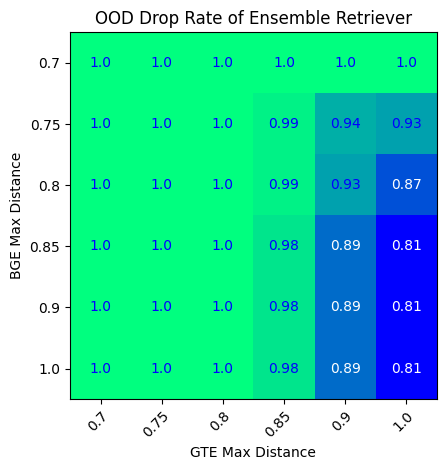

In [17]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


bge_max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
gte_max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

ood_drs = np.array(OOD_DRS).reshape([6, 6])

fig, ax = plt.subplots()
im = ax.imshow(ood_drs, cmap='winter')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(gte_max_dists)), labels=gte_max_dists)
ax.set_xlabel('GTE Max Distance')

ax.set_yticks(np.arange(len(bge_max_dists)), labels=bge_max_dists)
ax.set_ylabel('BGE Max Distance')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(bge_max_dists)):
    for j in range(len(gte_max_dists)):
        text = ax.text(j, i, ood_drs[i, j], ha="center", va="center", color="b" if ood_drs[i, j] > 0.9 else 'w')

ax.set_title("OOD Drop Rate of Ensemble Retriever")
fig.tight_layout()
plt.savefig('ood_dr_ens_md.svg', format='svg')
plt.show()

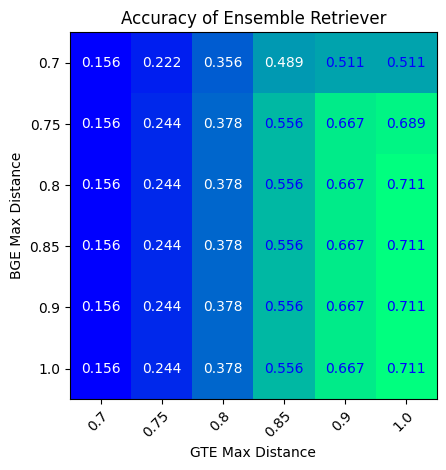

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl


bge_max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
gte_max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]

accs = np.array(ACCS).reshape([6, 6])

fig, ax = plt.subplots()
im = ax.imshow(accs, cmap='winter')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(gte_max_dists)), labels=gte_max_dists)
ax.set_xlabel('GTE Max Distance')

ax.set_yticks(np.arange(len(bge_max_dists)), labels=bge_max_dists)
ax.set_ylabel('BGE Max Distance')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(bge_max_dists)):
    for j in range(len(gte_max_dists)):
        text = ax.text(j, i, f'{accs[i, j]:.3f}', ha="center", va="center", color="w" if accs[i, j] < 0.5 else 'b')

ax.set_title("Accuracy of Ensemble Retriever")
fig.tight_layout()
plt.savefig('acc_ens_md.svg', format='svg')
plt.show()

### Pareto Curve of Configs

Accuracy vs. OOD Drop Rate

In [15]:
for i, (acc, ooddr) in enumerate(zip(ACCS_BGE, OOD_DRS_BGE)):
    if acc > 0.7 and ooddr > 0.8:
        print(i, acc, ooddr)

13 0.7333333333333333 0.89


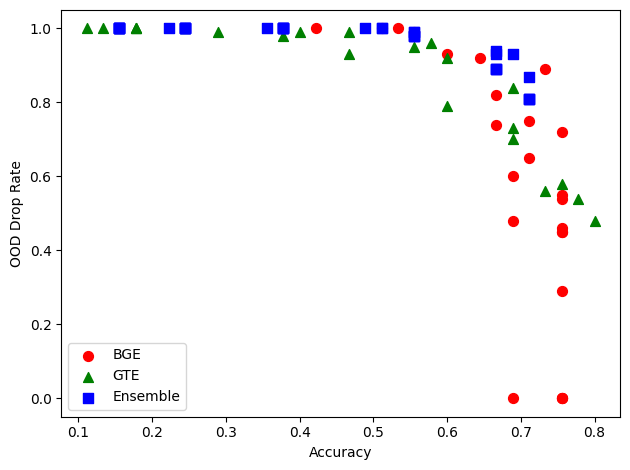

In [12]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots()

ax.scatter(ACCS_BGE, OOD_DRS_BGE, s=50, marker='o', color='r', label='BGE')
ax.scatter(ACCS_GTE, OOD_DRS_GTE, s=50, marker='^', color='g', label='GTE')
ax.scatter(ACCS_ENS, OOD_DRS_ENS, s=50, marker='s', color='b', label='Ensemble')

ax.set_xlabel('Accuracy')
ax.set_ylabel('OOD Drop Rate')
ax.legend()

fig.tight_layout()
plt.savefig('ooddr_acc_pareto.svg', format='svg')

## Readers

A reader answers the query based on the retrieved documents.  
We first test sub 3B models in order to fit in the 8GB RAM without quantization.

| Model | Good Response Rate (%) | Refusal Rate (%) | Avg. Latency (ms) |
| :- | :-: | :-: | -: |
| StableLM Zephyr 3B | 82.22 | 33.33 | 2611.6239 |
| Gemma 2B Instruct | 93.33 | 66.67 | 445.9849 |
| Phi-3 Mini 4K Instruct | 82.22 | 26.67 | 2688.8359 |

While Gemma seems to have a high good response rate, it is mostly caused by its high refusal rate, which is not ideal.  
Given StableLM and Phi-3 Mini have similar good response rate, a lower refusal rate indicates a higher correct answer rate.  
Thus, we choose Phi-3 Mini as our reader.

### StableLM Zephyr 3B

| QType | Correct | Refused | Bad |
| :- | -: | :-: | :-: |
| Textbook | 10 | 1 | 2 |
| Reading | 5 | 1 | 2 |
| Assignment | 1 | 6 | 1 |
| Logistics & Troubleshooting | 6 | 3 | 1 |
| Out-of-distribution | 0 | 4 | 1 |

Good Response Rate = 82.22%  
Refusal Rate = 33.33%

In [3]:
good_resp_rate = (11 + 6 + 7 + 9 + 4) / 45
refusal_rate = (1 + 1 + 6 + 3 + 4) / 45
f'{good_resp_rate=:.4f}, {refusal_rate=:.4f}'

'good_resp_rate=0.8222, refusal_rate=0.3333'

In [4]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter

os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()


model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')

@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


reader_name = 'stabilityai/stablelm-zephyr-3b'
tokenizer_r = AutoTokenizer.from_pretrained(reader_name)
reader = AutoModelForCausalLM.from_pretrained(reader_name, trust_remote_code=True).to('cuda')
instr_tmpl = '''\
Context information is below.
===
{context}
===
You are a helpful and educational teaching assistant for the computer architecture course.
Given the context information above and not prior knowledge, answer the query.
Respond "Sorry I cannot answer that" if no relevant information is in the context.
Query: {query}'''

def llm_complete(context, query):
    prompt = [{'role': 'user', 'content': instr_tmpl.format(context=context, query=query)}]
    in_tokens = tokenizer_r.apply_chat_template(prompt, add_generation_prompt=True, return_tensors='pt')
    out_tokens = reader.generate(in_tokens.to(model.device), max_new_tokens=256, do_sample=True, temperature=0.8)
    answer = tokenizer_r.decode(out_tokens[0, in_tokens.size(-1):], skip_special_tokens=True)
    return answer


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_reader(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    doc_src_paths = list(Path('data/').rglob('*.md'))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Query API
    def format_source(idx, top_doc):
        return f'[{idx}] {top_doc.metadata["source"]} | dist={top_doc.dist:.4f}\n{top_doc.page_content}'

    @time_fn
    def query_fn(query):
        if top_docs := retrieve_docs(query):
            context = '\n---\n'.join(top_doc.page_content for top_doc in top_docs)
            answer = llm_complete(context, query)
            sources = '\n\n'.join(format_source(i, top_doc) for i, top_doc in enumerate(top_docs, start=1))
        else:
            answer = 'Sorry, I do not have relevant information to answer the question.'
            sources = ''
        return answer, sources

    # Benchmarking
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)

    sum_t = 0.0
    reader_bmk = []

    for test in bmk:
        query, doc_src, id_phrase = test.values()
        (answer, sources), t = query_fn(query)
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    for query in ood_bmk:
        (answer, sources), t = query_fn(query)
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    with open(f'bmk_results/reader_bmk_{reader_name.split("/")[-1]}.json', 'w') as f:
        json.dump(reader_bmk, f)

    print(f'Average latency: {(sum_t / len(bmk)):.4f} ms')


benchmark_reader(chunk_size=128, overlap_ratio=0.5, top_k=15, max_dist=0.75)

query =  What are the strategies for replacing a cache block?
answer =  Based on the context provided, the strategies for replacing a cache block are as follows:

1. Random: In direct-mapped placement, candidate blocks are randomly selected to spread allocation uniformly.
2. Fully Associative or Set Associative: In these placement methods, there are many blocks to choose from on a miss, and the cache controller must decide which block to replace.
3. Variable Insertion-Point LRU: This replacement policy inserts entries from lower levels of the cache into a recency position below the most recently used position, which is proportional to the current number of upper level entries stored. This helps to reduce the miss time and optimize the cache usage.

These strategies help in controlling the miss rate and minimizing the number of cache misses in a cache-based system.
query =  What does a page table contain?
answer =  A page table contains the physical page numbers for the next lower level

### Gemma 2B Instruct


| QType | Correct | Refused | Bad |
| :- | -: | :-: | :-: |
| Textbook | 7 | 4 | 2 |
| Reading | 4 | 3 | 0 |
| Assignment | 0 | 8 | 0 |
| Logistics & Troubleshooting | 1 | 10 | 0 |
| Out-of-distribution | 0 | 5 | 0 |

Good Response Rate = 93.33%  
Refusal Rate = 66.67%

In [4]:
good_resp_rate = (11 + 7 + 8 + 11 + 5) / 45
refusal_rate = (4 + 3 + 8 + 10 + 5) / 45
f'{good_resp_rate=:.4f}, {refusal_rate=:.4f}'

'good_resp_rate=0.9333, refusal_rate=0.6667'

In [2]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter

os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()


model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')

@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


reader_name = 'google/gemma-2b-it'
tokenizer_r = AutoTokenizer.from_pretrained(reader_name)
reader = AutoModelForCausalLM.from_pretrained(reader_name, torch_dtype=torch.bfloat16).to('cuda')
instr_tmpl = '''\
Context information is below.
===
{context}
===
You are a helpful and educational teaching assistant for the computer architecture course.
Given the context information above and not prior knowledge, answer the query.
Respond "Sorry I cannot answer that" if no relevant information is in the context.
Query: {query}'''

def llm_complete(context, query):
    prompt = [{'role': 'user', 'content': instr_tmpl.format(context=context, query=query)}]
    in_tokens = tokenizer_r.apply_chat_template(prompt, add_generation_prompt=True, return_tensors='pt')
    out_tokens = reader.generate(in_tokens.to(model.device), max_new_tokens=256)
    answer = tokenizer_r.decode(out_tokens[0, in_tokens.size(-1):], skip_special_tokens=True)
    return answer


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_reader(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    doc_src_paths = list(Path('data/').rglob('*.md'))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Query API
    def format_source(idx, top_doc):
        return f'[{idx}] {top_doc.metadata["source"]} | dist={top_doc.dist:.4f}\n{top_doc.page_content}'

    @time_fn
    def query_fn(query):
        if top_docs := retrieve_docs(query):
            context = '\n---\n'.join(top_doc.page_content for top_doc in top_docs)
            answer = llm_complete(context, query)
            sources = '\n\n'.join(format_source(i, top_doc) for i, top_doc in enumerate(top_docs, start=1))
        else:
            answer = 'Sorry, I do not have relevant information to answer the question.'
            sources = ''
        return answer, sources

    # Benchmarking
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)

    sum_t = 0.0
    reader_bmk = []

    for test in bmk:
        query, doc_src, id_phrase = test.values()
        (answer, sources), t = query_fn(query)
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    for query in ood_bmk:
        (answer, sources), t = query_fn(query)
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    with open(f'bmk_results/reader_bmk_{reader_name.split("/")[-1]}.json', 'w') as f:
        json.dump(reader_bmk, f)

    print(f'Average latency: {(sum_t / len(bmk)):.4f} ms')

benchmark_reader(chunk_size=128, overlap_ratio=0.5, top_k=15, max_dist=0.75)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

query =  What are the strategies for replacing a cache block?
answer =  Sure, here are the strategies for replacing a cache block:

- Random—To spread allocation uniformly, candidate blocks are randomly selected.
- Fully associative or set associative placement—There are many blocks to choose from on a miss.
- Variable insertion-point LRU—Entries from lower levels of the cache are inserted into a recency position below the most recently used position that is proportional to the current number of upper level entries stored.
query =  What does a page table contain?
answer =  A page table contains the physical page number for either the next lower level page table page or the data page.
query =  What are the 3 pipeline hazards?
answer =  The 3 pipeline hazards are:

1. Control hazards arise from the pipelining of branches and other instructions that change the PC.

2. Data hazards arise when an instruction depends on the results of a previous instruction in a way that is exposed by the ov

### Phi-3 Mini 4K Instruct

| QType | Correct | Refused | Bad |
| :- | -: | :-: | :-: |
| Textbook | 12 | 0 | 1 |
| Reading | 6 | 1 | 1 |
| Assignment | 1 | 4 | 3 |
| Logistics & Troubleshooting | 6 | 3 | 2 |
| Out-of-distribution | 0 | 4 | 1 |

Good Response Rate = 82.22%  
Refusal Rate = 26.67%

In [5]:
good_resp_rate = (12 + 7 + 5 + 9 + 4) / 45
refusal_rate = (1 + 4 + 3 + 4) / 45
f'{good_resp_rate=:.4f}, {refusal_rate=:.4f}'

'good_resp_rate=0.8222, refusal_rate=0.2667'

In [2]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter

os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()


model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')

@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


reader_name = 'microsoft/Phi-3-mini-4k-instruct'
tokenizer_r = AutoTokenizer.from_pretrained(reader_name)
reader = AutoModelForCausalLM.from_pretrained(
    reader_name, trust_remote_code=True,
    quantization_config=BitsAndBytesConfig(load_in_8bit=True),
    device_map='cuda'
)
instr_tmpl = '''\
Context information is below.
===
{context}
===
You are a helpful and educational teaching assistant for the computer architecture course.
Given the context information above and not prior knowledge, answer the query.
Respond "Sorry I cannot answer that" if no relevant information is in the context.
Query: {query}'''

def llm_complete(context, query):
    prompt = [{'role': 'user', 'content': instr_tmpl.format(context=context, query=query)}]
    in_tokens = tokenizer_r.apply_chat_template(prompt, add_generation_prompt=True, return_tensors='pt')
    out_tokens = reader.generate(in_tokens.to(model.device), max_new_tokens=256, temperature=0.0, do_sample=False)
    answer = tokenizer_r.decode(out_tokens[0, in_tokens.size(-1):], skip_special_tokens=True)
    return answer


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_reader(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    doc_src_paths = list(Path('data/').rglob('*.md'))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Query API
    def format_source(idx, top_doc):
        return f'[{idx}] {top_doc.metadata["source"]} | dist={top_doc.dist:.4f}\n{top_doc.page_content}'

    @time_fn
    def query_fn(query):
        if top_docs := retrieve_docs(query):
            context = '\n---\n'.join(top_doc.page_content for top_doc in top_docs)
            answer = llm_complete(context, query)
            sources = '\n\n'.join(format_source(i, top_doc) for i, top_doc in enumerate(top_docs, start=1))
        else:
            answer = 'Sorry, I do not have relevant information to answer the question.'
            sources = ''
        return answer, sources

    # Benchmarking
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)

    sum_t = 0.0
    reader_bmk = []

    for test in bmk:
        query, doc_src, id_phrase = test.values()
        (answer, sources), t = query_fn(query)
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    for query in ood_bmk:
        (answer, sources), t = query_fn(query)
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    with open(f'bmk_results/reader_bmk_{reader_name.split("/")[-1]}.json', 'w') as f:
        json.dump(reader_bmk, f)

    print(f'Average latency: {(sum_t / len(bmk)):.4f} ms')

benchmark_reader(chunk_size=128, overlap_ratio=0.5, top_k=15, max_dist=0.75)

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/nfshome/tchen307/.miniconda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
You are not running the flash-attention implementation, expect numerical differences.


query =  What are the strategies for replacing a cache block?
answer =  Based on the provided context, the strategies for replacing a cache block are not explicitly mentioned. However, the context does discuss cache management and memory consistency, which are related to cache replacement policies. While it doesn't detail specific strategies for cache block replacement, we can infer that understanding memory consistency and the order of memory operations is crucial when considering how cache blocks are managed and replaced.

Common cache replacement strategies include:

1. Least Recently Used (LRU): Replaces the cache block that has not been accessed for the longest time.
2. First-In-First-Out (FIFO): Replaces the cache block that was loaded first.
3. Random Replacement: Replaces a randomly selected cache block.
4. Least Frequently Used (LFU): Replaces the cache block that has been accessed the least frequently.
5. Most Recently Used (MRU): Replaces the cache block that was most recent

### LLaMA 3 8B Instruct - 4 Bit Quantized

In [1]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter

os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()


model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')

@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


reader_name = 'alokabhishek/Meta-Llama-3-8B-Instruct-bnb-4bit'
tokenizer_r = AutoTokenizer.from_pretrained(reader_name)

reader = AutoModelForCausalLM.from_pretrained(reader_name, device_map='cuda')
system_prompt_tmpl = '''\
Context information is below.
===
{context}
===
You are a helpful and educational teaching assistant for the computer architecture course.
Given the context information above and not prior knowledge, answer the query.
Respond "Sorry I cannot answer that" if no relevant information is in the context.'''

def llm_complete(context, query):
    prompt = [
        {'role': 'system', 'content': system_prompt_tmpl.format(context=context)},
        {'role': 'user', 'content': query}
    ]
    in_tokens = tokenizer_r.apply_chat_template(prompt, add_generation_prompt=True, return_tensors='pt')
    out_tokens = reader.generate(
        in_tokens.to(model.device),
        eos_token_id=[tokenizer_r.eos_token_id, tokenizer_r.convert_tokens_to_ids('<|eot_id|>')],
        max_new_tokens=256, temperature=0.6, top_p=0.9, do_sample=True,
    )
    answer = tokenizer_r.decode(out_tokens[0, in_tokens.size(-1):], skip_special_tokens=True)
    return answer


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_reader(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    doc_src_paths = list(Path('data/').rglob('*.md'))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Query API
    def format_source(idx, top_doc):
        return f'[{idx}] {top_doc.metadata["source"]} | dist={top_doc.dist:.4f}\n{top_doc.page_content}'

    @time_fn
    def query_fn(query):
        if top_docs := retrieve_docs(query):
            context = '\n---\n'.join(top_doc.page_content for top_doc in top_docs)
            answer = llm_complete(context, query)
            sources = '\n\n'.join(format_source(i, top_doc) for i, top_doc in enumerate(top_docs, start=1))
        else:
            answer = 'Sorry, I do not have relevant information to answer the question.'
            sources = ''
        return answer, sources

    # Benchmarking
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)

    sum_t = 0.0
    reader_bmk = []

    for test in bmk:
        query, doc_src, id_phrase = test.values()
        (answer, sources), t = query_fn(query)
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    for query in ood_bmk:
        (answer, sources), t = query_fn(query)
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    with open(f'bmk_results/reader_bmk_{reader_name.split("/")[-1]}.json', 'w') as f:
        json.dump(reader_bmk, f)

    print(f'Average latency: {(sum_t / len(bmk)):.4f} ms')

benchmark_reader(chunk_size=128, overlap_ratio=0.5, top_k=15, max_dist=0.75)

model-00001-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.05G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/194 [00:00<?, ?B/s]

query =  What are the strategies for replacing a cache block?
answer =  According to the provided context, there are three primary strategies employed for selecting which block to replace on a cache miss:

1. Random: To spread allocation uniformly, candidate blocks are randomly selected.
2. LRU (Least Recently Used): This strategy selects the block that was referenced longest ago, so every access must update the LRU bit.
query =  What does a page table contain?
answer =  According to the context information, a page table contains the physical page number for either the next lower level page table page (for L4, L3, and L2) or the data page (for L1). Additionally, each entry in the page table contains various fields such as:

* Presence: indicates whether the page is present in memory
* Read/Write: indicates whether the page is read-only or read-write
* User/Supervisor: indicates whether a user can access the page or if it is limited to the upper three privilege levels
* Dirty: indicates

## Separating Assignments from Indexed Questions

### Create Separate Document Source Paths

In [5]:
import json
from pathlib import Path

all_doc_src_paths = list(map(str, Path('data/').rglob('*.md')))
doc_src_paths = list(filter(lambda p: not p.startswith('data/asmt'), all_doc_src_paths))
asmt_paths = list(filter(lambda p: p.startswith('data/asmt'), all_doc_src_paths))

with open('data/doc_src_paths_no_asmt.json', 'w') as f:
    json.dump(doc_src_paths, f, indent=2)

with open('data/asmt_paths.json', 'w') as f:
    json.dump(asmt_paths, f, indent=2)

### Experiment

In [1]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter

os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()


model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')

@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


reader_name = 'stabilityai/stablelm-zephyr-3b'
tokenizer_r = AutoTokenizer.from_pretrained(reader_name)
reader = AutoModelForCausalLM.from_pretrained(reader_name, trust_remote_code=True).to('cuda')
instr_tmpl = '''\
Context information is below.
===
{context}
===
You are a helpful and educational teaching assistant for the computer architecture course.
Given the context information above and not prior knowledge, answer the query.
Respond "Sorry I cannot answer that" if no relevant information is in the context.
Query: {query}'''

def llm_complete(context, query):
    prompt = [{'role': 'user', 'content': instr_tmpl.format(context=context, query=query)}]
    in_tokens = tokenizer_r.apply_chat_template(prompt, add_generation_prompt=True, return_tensors='pt')
    out_tokens = reader.generate(in_tokens.to(model.device), max_new_tokens=256, do_sample=True, temperature=0.8)
    answer = tokenizer_r.decode(out_tokens[0, in_tokens.size(-1):], skip_special_tokens=True)
    return answer


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_reader(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths_no_asmt.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}_no_asmt.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Query API
    def format_source(idx, top_doc):
        return f'[{idx}] {top_doc.metadata["source"]} | dist={top_doc.dist:.4f}\n{top_doc.page_content}'

    @time_fn
    def query_fn(query, doc_src):
        if doc_src.startswith('asmt'):
            asmt_name = doc_src.split('-')[0]
            with open(f'data/asmt/{asmt_name}/{doc_src}.md') as f:
                context = f.read()
            answer = llm_complete(context, query)
            sources = context
        else:
            if top_docs := retrieve_docs(query):
                context = '\n---\n'.join(top_doc.page_content for top_doc in top_docs)
                answer = llm_complete(context, query)
                sources = '\n\n'.join(format_source(i, top_doc) for i, top_doc in enumerate(top_docs, start=1))
            else:
                answer = 'Sorry, I do not have relevant information to answer the question.'
                sources = ''
        return answer, sources

    # Benchmarking
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)

    sum_t = 0.0
    reader_bmk = []

    for test in bmk:
        query, doc_src, id_phrase = test.values()
        (answer, sources), t = query_fn(query, doc_src)
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    for query in ood_bmk:
        (answer, sources), t = query_fn(query, '')
        sum_t += t
        reader_bmk.append({'query': query, 'answer': answer, 'sources': sources})
        print('query = ', query)
        print('answer = ', answer)
        print('='*30)

    with open(f'bmk_results/reader_bmk_{reader_name.split("/")[-1]}_no_asmt.json', 'w') as f:
        json.dump(reader_bmk, f, indent=2)

    print(f'Average latency: {(sum_t / len(bmk)):.4f} ms')


benchmark_reader(chunk_size=128, overlap_ratio=0.5, top_k=15, max_dist=0.75)

query =  What are the strategies for replacing a cache block?
answer =  The strategies for replacing a cache block, as mentioned in the context information provided, include:

1. Random: Candidate blocks are randomly selected to spread allocation uniformly.
2. LRU (Least Recently Used): The cache controller selects the cache block that was referenced the longest ago.

In the context of variable insertion-point LRU replacement policy, entries from lower levels of the cache are inserted into a recency position below the most recently used position that is proportional to the current number of upper level entries stored. This helps in reducing the miss time and optimizing the cache performance.
query =  What does a page table contain?
answer =  A page table contains the physical page addresses, indexed by the virtual page number. It is a data structure that helps in paging, and its size is determined by the number of pages in the virtual address space. Each entry in the page table provide

# Scratch

In [9]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to('cuda')


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k, max_dist):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    doc_src_paths = list(Path('data/').rglob('*.md'))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < max_dist, zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    n_pos = 0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs = retrieve_docs(query)
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    n_drop = 0
    with open('data/benchmark_ood.json') as f:
        ood_bmk = json.load(f)
    for query in ood_bmk:
        top_docs = retrieve_docs(query)
        n_drop += top_k - len(top_docs)
        if n_drop == top_k:
            n_pos += 1

    acc = n_pos / (len(bmk) + len(ood_bmk))
    drop_ratio = n_drop / (top_k * len(ood_bmk))
    print(f'| {max_dist:.2f} | {drop_ratio:.3f} | {acc:.3f} |')


print('| Max Distance | OOD Drop Ratio | Accuracy |')
print('| :-: | :-: | :-: |')
max_dists = [0.7, 0.75, 0.8, 0.85, 0.9, 1.0]
for max_dist_ in max_dists:
    benchmark_retriever(128, 0.25, 15, max_dist_)

| Max Distance | OOD Drop Ratio | Accuracy |
| :-: | :-: | :-: |
| 0.70 | 1.000 | 0.489 |
| 0.75 | 0.893 | 0.622 |
| 0.80 | 0.733 | 0.711 |
| 0.85 | 0.507 | 0.756 |
| 0.90 | 0.360 | 0.756 |
| 1.00 | 0.000 | 0.756 |


## Best Retriever Config

We benchmark the following configurations, each with overlapping ratio [0.0, 0.25, 0.5, 0.75].
We set `n_trees` and `search_k` as the number of documents, since we can afford the maximum latency.

| Chunk Size | Top K |
| :-: | :- |
| 128 | 5, 10, 15, 20 |
| 256 | 5, 10 |
| 512 | 5 |

The results show that chunk size 128 with top 15 documents achieves best accuracy

Thus, the best configuration is `chunk size 128 / overlap ratio 0.25 / top k 15`

| Chunk Size | Overlap Ratio | N Trees | Top K | Accuracy | Latency (ms) |
| :-: | :-: | :- | :- | :-: | -: |
| 128 | 0.00 | 4772 | 5 | 0.750 | 5.8781 |
| 128 | 0.25 | 5546 | 5 | 0.675 | 6.5106 |
| 128 | 0.50 | 7768 | 5 | 0.700 | 8.4311 |
| 128 | 0.75 | 12867 | 5 | 0.725 | 13.6955 |
| 128 | 0.00 | 4772 | 10 | 0.775 | 5.9647 |
| 128 | 0.25 | 5546 | 10 | 0.800 | 7.9960 |
| 128 | 0.50 | 7768 | 10 | 0.775 | 8.3959 |
| 128 | 0.75 | 12867 | 10 | 0.800 | 12.9225 |
| 128 | 0.00 | 4772 | 15 | 0.775 | 5.9467 |
| 128 | 0.25 | 5546 | 15 | 0.850 | 6.5670 |
| 128 | 0.50 | 7768 | 15 | 0.825 | 8.6119 |
| 128 | 0.75 | 12867 | 15 | 0.825 | 13.1510 |
| 128 | 0.00 | 4772 | 20 | 0.775 | 6.1845 |
| 128 | 0.25 | 5546 | 20 | 0.850 | 6.9397 |
| 128 | 0.50 | 7768 | 20 | 0.850 | 8.7540 |
| 128 | 0.75 | 12867 | 20 | 0.850 | 13.5192 |
| 256 | 0.00 | 2198 | 5 | 0.750 | 3.9276 |
| 256 | 0.25 | 2673 | 5 | 0.775 | 4.3566 |
| 256 | 0.50 | 3791 | 5 | 0.600 | 5.2735 |
| 256 | 0.75 | 6868 | 5 | 0.700 | 7.8363 |
| 256 | 0.00 | 2198 | 10 | 0.775 | 4.0008 |
| 256 | 0.25 | 2673 | 10 | 0.825 | 4.3942 |
| 256 | 0.50 | 3791 | 10 | 0.700 | 5.2689 |
| 256 | 0.75 | 6868 | 10 | 0.750 | 8.5175 |
| 512 | 0.00 | 1061 | 5 | 0.750 | 3.6841 |
| 512 | 0.25 | 1311 | 5 | 0.825 | 3.5690 |
| 512 | 0.50 | 1866 | 5 | 0.800 | 3.7797 |
| 512 | 0.75 | 3409 | 5 | 0.700 | 4.9728 |

In [6]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'BAAI/bge-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to('cuda')


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state[:, 0, :], p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    with open('data/doc_src_paths.json') as f:
        doc_src_paths = list(map(Path, json.load(f)))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_bge_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)
    
        top_docs = []
        for dist, idx in zip(dists, idxs):
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    with open('data/benchmark.json') as f:
        bmk = json.load(f)

    n_pos = 0
    r_time = 0.0
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        r_time += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    acc = n_pos / len(bmk)
    avg_t = r_time / len(bmk)
    print(f'| {chunk_size} | {overlap_ratio:.2f} | {n_trees} | {top_k} | {acc:.3f} | {avg_t:.4f} |')


print('| Chunk Size | Overlap Ratio | N Trees | Top K | Accuracy | Average Latency (ms) |')
print('| :-: | :-: | :- | :- | :-: | -: |')
configs = [
    (128, 5), (128, 10), (128, 15), (128, 20),
    (256, 5), (256, 10),
    (512, 5)
]
for chunk_size_, top_k_ in configs:
    for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
        benchmark_retriever(chunk_size_, overlap_ratio_, top_k_)

| Chunk Size | Overlap Ratio | N Trees | Top K | Accuracy | Average Latency (ms) |
| :-: | :-: | :- | :- | :-: | :-: |
| 128 | 0.00 | 4772 | 5 | 0.750 | 5.8781 |
| 128 | 0.25 | 5546 | 5 | 0.675 | 6.5106 |
| 128 | 0.50 | 7768 | 5 | 0.700 | 8.4311 |
| 128 | 0.75 | 12867 | 5 | 0.725 | 13.6955 |
| 128 | 0.00 | 4772 | 10 | 0.775 | 5.9647 |
| 128 | 0.25 | 5546 | 10 | 0.800 | 7.9960 |
| 128 | 0.50 | 7768 | 10 | 0.775 | 8.3959 |
| 128 | 0.75 | 12867 | 10 | 0.800 | 12.9225 |
| 128 | 0.00 | 4772 | 15 | 0.775 | 5.9467 |
| 128 | 0.25 | 5546 | 15 | 0.850 | 6.5670 |
| 128 | 0.50 | 7768 | 15 | 0.825 | 8.6119 |
| 128 | 0.75 | 12867 | 15 | 0.825 | 13.1510 |
| 128 | 0.00 | 4772 | 20 | 0.775 | 6.1845 |
| 128 | 0.25 | 5546 | 20 | 0.850 | 6.9397 |
| 128 | 0.50 | 7768 | 20 | 0.850 | 8.7540 |
| 128 | 0.75 | 12867 | 20 | 0.850 | 13.5192 |
| 256 | 0.00 | 2198 | 5 | 0.750 | 3.9276 |
| 256 | 0.25 | 2673 | 5 | 0.775 | 4.3566 |
| 256 | 0.50 | 3791 | 5 | 0.600 | 5.2735 |
| 256 | 0.75 | 6868 | 5 | 0.700 | 7.8363 |
|

## Single Retriever - GTE

Embedding model `Alibaba-NLP/gte-base-en-v1.5` outperforms `BAAI/bge-base-en-v1.5`,  
achieving 90% accuracy with configuration `chunk_size=128, overlap_ratio=0.5, top_k=15`.

| Chunk Size | Overlap Ratio | N Trees | Top K | Accuracy | Latency (ms) |
| :-: | :-: | :- | :- | :-: | -: |
| 128 | 0.00 | 4772 | 5 | 0.725 | 5.9780 |
| 128 | 0.25 | 5546 | 5 | 0.750 | 6.3845 |
| 128 | 0.50 | 7768 | 5 | 0.750 | 8.1127 |
| 128 | 0.75 | 12867 | 5 | 0.675 | 12.7021 |
| 128 | 0.00 | 4772 | 10 | 0.825 | 5.9814 |
| 128 | 0.25 | 5546 | 10 | 0.825 | 6.4193 |
| 128 | 0.50 | 7768 | 10 | 0.850 | 8.1309 |
| 128 | 0.75 | 12867 | 10 | 0.775 | 12.6921 |
| 128 | 0.00 | 4772 | 15 | 0.825 | 5.9963 |
| 128 | 0.25 | 5546 | 15 | 0.850 | 6.4255 |
| 128 | 0.50 | 7768 | 15 | 0.900 | 8.1430 |
| 128 | 0.75 | 12867 | 15 | 0.875 | 12.7356 |
| 128 | 0.00 | 4772 | 20 | 0.825 | 5.9743 |
| 128 | 0.25 | 5546 | 20 | 0.850 | 6.4221 |
| 128 | 0.50 | 7768 | 20 | 0.900 | 8.1509 |
| 128 | 0.75 | 12867 | 20 | 0.875 | 12.7124 |
| 256 | 0.00 | 2198 | 5 | 0.625 | 4.1689 |
| 256 | 0.25 | 2673 | 5 | 0.750 | 4.3880 |
| 256 | 0.50 | 3791 | 5 | 0.675 | 4.9053 |
| 256 | 0.75 | 6868 | 5 | 0.750 | 7.0687 |
| 256 | 0.00 | 2198 | 10 | 0.700 | 4.1731 |
| 256 | 0.25 | 2673 | 10 | 0.825 | 4.3987 |
| 256 | 0.50 | 3791 | 10 | 0.825 | 4.9369 |
| 256 | 0.75 | 6868 | 10 | 0.775 | 7.0895 |
| 512 | 0.00 | 1061 | 5 | 0.600 | 3.7315 |
| 512 | 0.25 | 1311 | 5 | 0.700 | 3.7881 |
| 512 | 0.50 | 1866 | 5 | 0.675 | 4.0525 |
| 512 | 0.75 | 3409 | 5 | 0.600 | 4.8636 |

In [4]:
import os
import json
from pathlib import Path
from time import perf_counter_ns

import torch
import torch.nn.functional as F

from annoy import AnnoyIndex
from transformers import AutoTokenizer, AutoModel
from transformers import logging as tf_logging
from langchain_core.documents import Document
from llama_index.core.node_parser import SentenceSplitter


os.environ['TOKENIZERS_PARALLELISM'] = '(true | false)'
tf_logging.set_verbosity_error()

model_name = 'Alibaba-NLP/gte-base-en-v1.5'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to('cuda')


@torch.no_grad()
def vector_embed(text):
    input_tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    output = model(**{k: v.to(model.device) for k, v in input_tokens.items()})
    embd = F.normalize(output.last_hidden_state.mean(dim=1), p=2, dim=1)  # Last hidden state: [1, seq_len, 768]
    return embd.to('cpu').reshape(-1)


def match_doc_src(doc, doc_src, id_phrase):
    match_src = Path(doc.metadata['source']).stem == doc_src
    match_content = id_phrase in doc.page_content
    return match_src and match_content


def time_fn(fn):
    def wrap(*args, **kwargs):
        tik = perf_counter_ns()
        output = fn(*args, **kwargs)
        tok = perf_counter_ns()
        return output, (tok - tik) / 1e6
    return wrap


def benchmark_retriever(chunk_size, overlap_ratio, top_k):
    # Creating documents
    docs = []
    parser = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=int(chunk_size*overlap_ratio))
    doc_src_paths = list(Path('data/').rglob('*.md'))
    
    for doc_src_path in doc_src_paths:
        with open(doc_src_path) as f:
            doc_src = f.read()
        doc_chunks = parser.split_text(doc_src)
        docs.extend(
            Document(page_content=txt, metadata={'source': doc_src_path.name}) for txt in doc_chunks
        )

    # Creating vector index
    n_trees = len(docs)
    filename = f'.ann/idx_gte_{chunk_size}_{int(chunk_size*overlap_ratio)}_{n_trees}.ann'
    vector_idx = AnnoyIndex(768, 'euclidean')  # Hidden dim of BERT = 768
    if not Path(filename).exists():
        for i, doc in enumerate(docs):
            embd = vector_embed(doc.page_content)
            vector_idx.add_item(i, embd)
        vector_idx.build(n_trees)
        vector_idx.save(filename)
    else:
        vector_idx.load(filename)

    @time_fn
    def retrieve_docs(query):
        '''Output: List[tuple(float, int)]: (distance, doc_idx)'''
        q_embd = vector_embed(query)
        idxs, dists = vector_idx.get_nns_by_vector(q_embd, top_k, len(docs), include_distances=True)

        top_doc_idxs = filter(lambda p: p[0] < float('inf'), zip(dists, idxs))
        top_docs = []
        for dist, idx in top_doc_idxs:
            top_doc = docs[idx].copy(update={'dist': dist})
            top_docs.append(top_doc)
    
        return top_docs

    # Benchmarking
    n_pos = 0
    sum_t = 0.0
    with open('data/benchmark.json') as f:
        bmk = json.load(f)
    for test in bmk:
        query, doc_src, id_phrase = test.values()
        top_docs, t = retrieve_docs(query)
        sum_t += t
        if any(match_doc_src(top_doc, doc_src, id_phrase) for top_doc in top_docs):
            n_pos += 1

    acc = n_pos / len(bmk)
    avg_t = sum_t / len(bmk)
    print(f'| {chunk_size} | {overlap_ratio:.2f} | {n_trees} | {top_k} | {acc:.3f} | {avg_t:.4f} |')


print('| Chunk Size | Overlap Ratio | N Trees | Top K | Accuracy | Latency (ms) |')
print('| :-: | :-: | :- | :- | :-: | -: |')
configs = [
    (128, 5), (128, 10), (128, 15), (128, 20),
    (256, 5), (256, 10),
    (512, 5)
]
for chunk_size_, top_k_ in configs:
    for overlap_ratio_ in [0.0, 0.25, 0.5, 0.75]:
        benchmark_retriever(chunk_size_, overlap_ratio_, top_k_)

| Chunk Size | Overlap Ratio | N Trees | Top K | Accuracy | Latency (ms) |
| :-: | :-: | :- | :- | :-: | -: |
| 128 | 0.00 | 4772 | 5 | 0.725 | 5.9780 |
| 128 | 0.25 | 5546 | 5 | 0.750 | 6.3845 |
| 128 | 0.50 | 7768 | 5 | 0.750 | 8.1127 |
| 128 | 0.75 | 12867 | 5 | 0.675 | 12.7021 |
| 128 | 0.00 | 4772 | 10 | 0.825 | 5.9814 |
| 128 | 0.25 | 5546 | 10 | 0.825 | 6.4193 |
| 128 | 0.50 | 7768 | 10 | 0.850 | 8.1309 |
| 128 | 0.75 | 12867 | 10 | 0.775 | 12.6921 |
| 128 | 0.00 | 4772 | 15 | 0.825 | 5.9963 |
| 128 | 0.25 | 5546 | 15 | 0.850 | 6.4255 |
| 128 | 0.50 | 7768 | 15 | 0.900 | 8.1430 |
| 128 | 0.75 | 12867 | 15 | 0.875 | 12.7356 |
| 128 | 0.00 | 4772 | 20 | 0.825 | 5.9743 |
| 128 | 0.25 | 5546 | 20 | 0.850 | 6.4221 |
| 128 | 0.50 | 7768 | 20 | 0.900 | 8.1509 |
| 128 | 0.75 | 12867 | 20 | 0.875 | 12.7124 |
| 256 | 0.00 | 2198 | 5 | 0.625 | 4.1689 |
| 256 | 0.25 | 2673 | 5 | 0.750 | 4.3880 |
| 256 | 0.50 | 3791 | 5 | 0.675 | 4.9053 |
| 256 | 0.75 | 6868 | 5 | 0.750 | 7.0687 |
| 256 | 0.

## GTE Retriever Distance Threshold